<a href="https://colab.research.google.com/github/Ahmadar91/ML/blob/main/Lab_4_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['unique', 'array']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [3]:
from pandas import *
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [4]:
n_epochs = 2
batch_size_train = 64
batch_size_test = 10000
learning_rate = 0.01
momentum = 0.5


In [5]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader =  torch.utils.data.DataLoader(train_set, batch_size=batch_size_train, shuffle=True)

test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size_test, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 143286948.94it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 20756630.20it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41652712.33it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10548465.54it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



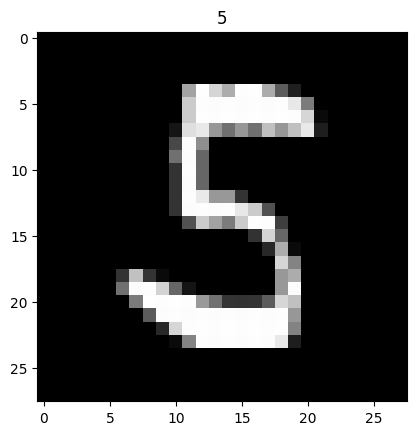

In [6]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

image = images[0]
label = labels[0]

image = image * 0.5 + 0.5

image = image.numpy()

plt.imshow(image.squeeze(), cmap='gray')

plt.title(str(label.item()))

plt.show()


In [78]:
class MyCNN(nn.Module):
    def __init__(self, kernel_size=2):
        super(MyCNN, self).__init__()
        self.kernel_size = kernel_size
        input_size = 28
        con_stride=1
        print(self.kernel_size)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=self.kernel_size)
        conv_out_size = (input_size - self.kernel_size)  + 1
        print(f"conv_out_size: {conv_out_size}")
        self.pool = nn.MaxPool2d(2,2)
        pool_out_size = conv_out_size // 2
        print(f"pool_out_size: {pool_out_size}")
        input_size_after_conv_and_pool = 16 * pool_out_size * pool_out_size
        self.fc1 = nn.Linear(input_size_after_conv_and_pool , 32)
        #self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        #x = x.view(-1, np.product(x.shape[1:])) # not working
        #x = x.view(-1, np.product(x.shape)) # not working
        x = x.view(x.size(0), -1) # works
        #x=x.reshape(x.size(0),-1) # works
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        #print('test here ',np.shape(x))
        #x = F.relu(self.fc2(x))

        return x

In [21]:
class MyCNN(nn.Module):
    def __init__(self, kernel_size=2):
        super(MyCNN, self).__init__()
        self.kernel_size = kernel_size
        input_size = 28
        print(self.kernel_size)
        ouput_channels_value = 16
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=ouput_channels_value, kernel_size=self.kernel_size)
        conv_out_size = (input_size - self.kernel_size)  + 1
        print(f"conv_out_size: {conv_out_size}")
        self.pool = nn.MaxPool2d(2,2)
        pool_out_size = conv_out_size // 2
        print(f"pool_out_size: {pool_out_size}")
        input_size_after_conv_and_pool = ouput_channels_value * pool_out_size * pool_out_size

        self.fc1 = nn.Linear(input_size_after_conv_and_pool, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor before passing it to the fully connected layer
        x = F.relu(self.fc1(x))  # Apply ReLU after the fully connected layer `fc1`
        x = self.fc3(x)  # `fc3` should be the last layer in the forward pass
        return x


In [73]:
# Twan

class MyCNN(nn.Module):
    def __init__(self, kernel_size=2):
        super(MyCNN, self).__init__()
        self.kernel_size = kernel_size
        input_size = 28
        con_stride=1
        self.conv1 = nn.Conv2d(1, 16,self.kernel_size)
        conv_out_size = (input_size - self.kernel_size)  + 1
        print(f"conv_out_size: {conv_out_size}")
        self.pool = nn.MaxPool2d(2, 2)
        pool_out_size = conv_out_size // 2
        print(f"pool_out_size: {pool_out_size}")
        input_size_after_conv_and_pool = 16 * 13 * 13
        self.fc1 = nn.Linear(input_size_after_conv_and_pool , 32)
        #self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(173056, 10)

    def forward(self, x):
        self.features = F.relu(self.conv1(x))
        x = self.pool(self.features)
        print(x.shape)
        x = x.view(-1, np.product(x.shape))
        print(x.shape)
        x = self.fc3(x)
        #x = F.relu(self.fc1(x))
        #print('test here ',np.shape(x))
        #x = F.relu(self.fc2(x))
        return x

In [79]:
trainAccuracy = list()
testAccuracy = list()

model = MyCNN(5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)




5
conv_out_size: 24
pool_out_size: 12


In [ ]:
for inputs, labels in train_loader:
        inputs, labels = Variable(inputs), Variable(labels)
        outputs = model(inputs)

In [80]:

def train(model, train_loader, criterion, optimizer):
    model.train()
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    return train_accuracy

def test(model, test_loader):
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    return test_accuracy


for epoch in range(n_epochs):
    train_accuracy = train(model, train_loader, criterion, optimizer)
    trainAccuracy.append(train_accuracy)

    test_accuracy = test(model, test_loader)
    testAccuracy.append(test_accuracy)

    print(f'Epoch {epoch+1}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

print('Finished Training')


Epoch 1, Train Accuracy: 88.79%, Test Accuracy: 95.48%
Epoch 2, Train Accuracy: 96.18%, Test Accuracy: 97.09%
Finished Training


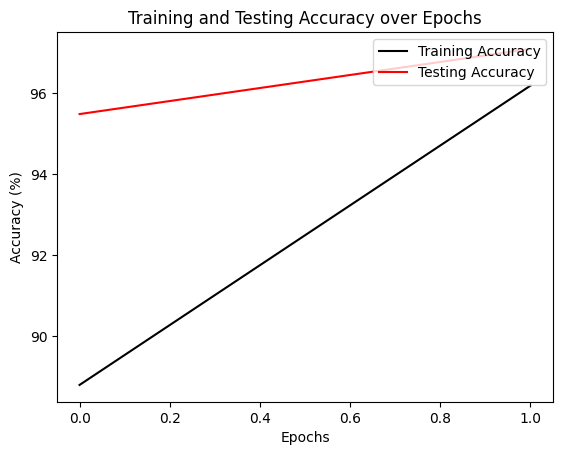

In [81]:


import matplotlib.pyplot as plt

plt.plot(trainAccuracy, 'k', label='Training Accuracy')
plt.plot(testAccuracy, 'r', label='Testing Accuracy')

plt.title('Training and Testing Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(loc='upper right')

plt.show()


In [ ]:
kernelSizes=[2,3,4,5]

for kernelSize in kernelSizes:
    trainAccuracy=list()
    testAccuracy=list()
    #instantiate your CNN using kernel size

    #define optimizer and loss function

    #train and test - you can copy the code

    #now plot this
    figure()
    plot(trainAccuracy,'k')
    plot(testAccuracy,'r')
    title("Kernel size: "+str(kernelSize))
